In [1]:
%matplotlib notebook
import keras as keras
from keras.models import Sequential
from keras.layers import LSTM, Dense,BatchNormalization,Dropout,Flatten, Conv1D
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras import regularizers,optimizers
from keras.regularizers import l2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import gzip
from keras.layers.core import Lambda
from scipy.integrate import trapz
import seaborn as sns

from keras.layers.core import Lambda
from keras import backend as K    


def mini_batches(InputSample,BatchSize):
    Index = np.array(range(InputSample.shape[0]),dtype=int)
    NumBatches = np.int(InputSample.shape[0]/BatchSize)
    Removed = np.array([],dtype=int)

    BatchInd =[]
    for BatchLoop in range(NumBatches):
        RemainIndex = np.delete(Index,Removed)
        SampleInd = np.random.choice(RemainIndex,size=BatchSize,replace=False)
        Removed = np.append(Removed,SampleInd,axis=0)

        BatchInd.append(SampleInd)
    RemainIndex = np.delete(Index,Removed)
    BatchInd.append(RemainIndex)

    return BatchInd,NumBatches
    
def Get_Feats_and_Targets(filename):
    import numpy as np
    
    def line_to_Feats(line):
        line = line.split(' ')
        Feats = np.asarray(line[0:1024])
        Target = np.zeros([3])
        Target[int(line[1024])] = 1
        return Feats,Target

    f = open(filename, 'r')
    lines = f.readlines()
    Features = []
    Targets = []
    for i in range(len(lines)-1):
        line = lines[i+1]
        Feats,Tgts = line_to_Feats(line)
        Features.append(Feats)
        Targets.append(Tgts)
        
    return np.asarray(Features,dtype = 'float64'), np.asarray(Targets,dtype = 'int')

Using TensorFlow backend.


In [2]:
[TrainInputs_Easy,TrainTargets_Easy] = Get_Feats_and_Targets('shapeset1_1cspo_2_3.10000.train.amat')
[ValInputs_Easy,ValTargets_Easy] = Get_Feats_and_Targets('shapeset1_1cspo_2_3.5000.valid.amat')

[TrainInputs,TrainTargets] = Get_Feats_and_Targets('shapeset2_1cspo_2_3.10000.train.amat')
[ValInputs,ValTargets] = Get_Feats_and_Targets('shapeset2_1cspo_2_3.5000.valid.amat')


In [3]:
FullTrainInputs = np.append(TrainInputs,TrainInputs_Easy,axis=0)
FullTrainTargets = np.append(TrainTargets,TrainTargets_Easy,axis=0)

FullValInputs = np.append(ValInputs,ValInputs_Easy,axis=0)
FullValTargets = np.append(ValTargets,ValTargets_Easy,axis=0)

In [4]:
data_dim = TrainInputs.shape[-1]
NumSamples = TrainInputs.shape[0]
Num_Targets = TrainTargets.shape[-1]

index = np.linspace(0,NumSamples,NumSamples,endpoint=False,dtype=int)

reg_coeff = 0

def Gen_Model(reg_coeff):
    model = Sequential()
    model.add(Dense(100,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dense(100,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dense(100,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
    optim = optimizers.sgd(lr=0.001)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])
    return model
    
ISHard_model = Gen_Model(reg_coeff)

ISEasy_model = Gen_Model(reg_coeff)

Cur_model = Gen_Model(reg_coeff)

Uni_model = Gen_Model(reg_coeff)

ISHard_model.set_weights(Uni_model.get_weights())
ISEasy_model.set_weights(Uni_model.get_weights())
Cur_model.set_weights(Uni_model.get_weights())

In [5]:
def average_dist_to_threshold(model,samples,Num_Targets):
    Output = model.predict(samples)
    Output -= 1/float(Num_Targets)
    Dist_to_Threshold = np.mean(np.abs(Output),1)
    return Dist_to_Threshold

def acquisition_function_dist_to_threshold(model,samples,Num_Targets,temperature=1,Rescale=0):
    Output = model.predict(samples)
    Output -= 1/float(Num_Targets)
    Dist_to_Threshold = np.sum(np.abs(Output),1)
    Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
    Exp_Dist_to_Threshold *= 1
#     Exp_Dist_to_Threshold = Dist_to_Threshold
    Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
    if Rescale == 1:
        Median_Prob = np.median(Sampling_Prob)
        Min_Prob = np.min(Sampling_Prob)
        Sampling_Prob[Sampling_Prob > Median_Prob] += Min_Prob/2
        Sampling_Prob[Sampling_Prob < Median_Prob] -= Min_Prob/2
    return Sampling_Prob

def Exp_ModelChange(Model,Inputs,Num_Targets):
    ExpChange = np.zeros(Inputs.shape[0])
    for TargetLoop in range(Num_Targets):
        thisTarget = np.zeros([Inputs.shape[0],Num_Targets])
        thisTarget[:,TargetLoop] = 1
        Model_Output = Model.predict(Inputs)
        ClassProb = Model_Output[:,TargetLoop]
        Loss = np.mean(Model_Output - Model_Output*thisTarget + np.log(1+np.exp(-Model_Output)),1)
        ExpChange += Loss*ClassProb
    return ExpChange

def acquisition_function_exp_model_change(model,samples,Num_Targets,Smoothing_Const=0,Rescale=0):
    ExpChange = np.exp(Exp_ModelChange(model,samples,Num_Targets)/Smoothing_Const)
#     Sampling_Prob = ExpChange/np.sum(ExpChange)
    Sampling_Prob = ExpChange/np.sum(ExpChange).astype(float)
    if Rescale == 1:
        Median_Prob = np.median(Sampling_Prob)
        Min_Prob = np.min(Sampling_Prob)
        Sampling_Prob[Sampling_Prob > Median_Prob] += Min_Prob/2
        Sampling_Prob[Sampling_Prob < Median_Prob] -= Min_Prob/2
    return Sampling_Prob

def Get_L2_Loss(Model,Coeff=0.01):
    Reg_Loss = 0
    Weights = Model.get_weights()
    NumWeights = len(Weights)
    for i in range(NumWeights):
        LayerWeights = Weights[i]
        LayerWeights_Sq = LayerWeights**2
        Reg_Loss += LayerWeights_Sq.sum()
    Reg_Loss*=Coeff
    return Reg_Loss


def ablate_network(model,ablation_perc):
    weights = model.get_weights()
    save_weights = weights.copy()
    NumLayers = len(weights)
    total_numweights  = 0 
    for i in range(NumLayers):
        layer = weights[i]
        total_numweights += len(layer.flatten())
    num_ablations = np.int(ablation_perc*total_numweights)
    weights = ablate_weights(weights,num_ablations)
    model.set_weights(weights)
        
    return(model,save_weights)


def ablation_curve(model,num_tests,max_perc,inputs,targets):
    Perc_Space = np.linspace(0,max_perc,num_tests)
    Performance = np.zeros(num_tests)
    for i in range(num_tests):
        model,save_weights = ablate_network(model,Perc_Space[i])
        Perf = model.test_on_batch(inputs,targets)
        Performance[i] = Perf[1]
        model.set_weights(save_weights)
        
        AUC = trapz(Performance,Perc_Space)
        
    return AUC,Performance
    
    
def ablate_weights(weights,num_ablations):
    NumLayers = len(weights)
    LayerShape = []
    LayerShape = []
    LayerNodes = [0]
    FlattenedNodes = np.empty([0])
    for i in range(NumLayers):
        LayerShape.append(weights[i].shape)
        LayerNodes.append(len(weights[i].flatten()))
        FlattenedNodes = np.append(FlattenedNodes,weights[i].flatten())
        Index = np.linspace(0,len(FlattenedNodes)-1,num=len(FlattenedNodes),dtype = int)
    RandChoice = np.random.choice(Index,size = num_ablations,replace=False)
    FlattenedNodes[RandChoice] = 0
    FirstInd = 0
    for i in range(NumLayers):
        FirstInd += LayerNodes[i]
        SecondInd = FirstInd + LayerNodes[i+1]
        Sample = FlattenedNodes[FirstInd:SecondInd]
        Sample = Sample.reshape(LayerShape[i])
        weights[i] = Sample
        
    return weights


def acquisition_function_ablation(model,Inputs,Targets,Cluster_Size,Rescale=0):
    BatchInd,NumBatches = mini_batches(Inputs,Cluster_Size)
    AUC_Record = np.zeros([Inputs.shape[0]])
    count= 0
    for Batch in BatchInd:
        if Batch.shape[0] != 0:
            BatchInputs = Inputs[Batch,:]
            BatchTargets = Targets[Batch,:]
            SaveWeights = model.get_weights()
            model.fit(BatchInputs,BatchTargets,batch_size=64,verbose=0)
            AUC,_ = ablation_curve(model,10,1,Inputs,Targets)
            AUC_Record[Batch] = AUC.copy()
            model.set_weights(SaveWeights)
            count +=1
        
    Sampling_Prob = AUC_Record/AUC_Record.sum()
    if Rescale == 1:
        Median_Prob = np.median(Sampling_Prob)
        Min_Prob = np.min(Sampling_Prob)
        Sampling_Prob[Sampling_Prob > Median_Prob] += Min_Prob/2
        Sampling_Prob[Sampling_Prob < Median_Prob] -= Min_Prob/2
    return Sampling_Prob
    
    


In [6]:
count = 0 
Num_Epochs = 256
Num_BurnIn = 20
Switch_Epoch = 128
Batch_Size = 1

Smoothing_Constant = 0

Val_Error = np.zeros([Num_Epochs,4])
Val_Acc = np.zeros([Num_Epochs,4])


<IPython.core.display.Javascript object>


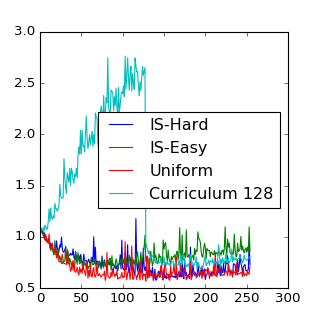

<IPython.core.display.Javascript object>


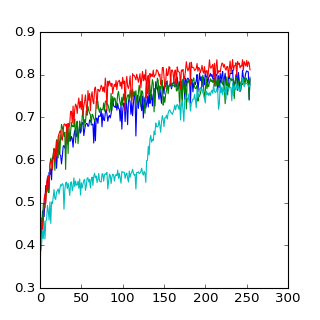

<IPython.core.display.Javascript object>


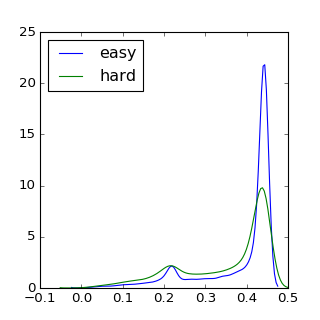

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
14.303045
20
14.290494
21
14.288791
22
14.069619
23
14.009919
24
14.151155
25
14.24779
26
14.091527
27
14.238832
28
14.190234
29
14.2019615
30
14.294598
31
14.31174
32
14.024128
33
14.048484
34
14.179053
35
14.141489
36
14.098981
37
13.990629
38
14.079554
39
14.0934725
40
14.1708975
41
14.221049
42
14.048886
43
14.132571
44
14.115933
45
13.860751
46
13.928314
47
13.758315
48
14.011083
49
13.808138
50
14.222013
51
14.190369
52
13.987398
53
14.117744
54
14.225866
55
14.259219
56
14.189757
57
14.218424
58
14.240972
59
14.271533
60
14.111103
61
14.167218
62
14.026821
63
14.0130205
64
14.218916
65
13.798655
66
14.231228
67
14.014672
68
14.081173
69
14.163894
70
14.216809
71
14.222124
72
14.341712
73
14.128659
74
14.176359
75
14.045096
76
14.072799
77
14.072676
78
13.816313
79
13.863451
80
14.135872
81
14.06577
82
13.84527
83
13.994751
84
14.151647
85
13.87691
86
13.873834
87
14.259829
88
14.178143
89
13.948364
90
14.140068
91
13.919765
92
13

In [7]:
fig = plt.figure(figsize = [4,4])
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

fig2 = plt.figure(figsize = [4,4])
ax2 = fig2.add_subplot(111)
plt.ion()
fig2.show()
fig2.canvas.draw()

fig3 = plt.figure(figsize = [4,4])
ax3 = fig3.add_subplot(111)
plt.ion()
fig3.show()
fig3.canvas.draw()

rec_count = 0
ell_count = 0
tri_count = 0

def Biased_Batch(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1):
    while True: 
        index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
#         Sampling_Probability = Sampling_Probability/Sampling_Probability.sum()
        Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
        Batch_Inputs = Inputs[Batch,:]
        Batch_Targets = Targets[Batch,:]
        targetsum = Batch_Targets.sum(axis=0)
        global rec_count
        rec_count += targetsum[0]
        global ell_count
        ell_count += targetsum[1]
        global tri_count
        tri_count += targetsum[2]
        if Weighting_Flag == 1:
            FullWeights = Sampling_Probability**-1
            FullWeights = FullWeights/np.mean(FullWeights)
        elif Weighting_Flag == -1:
            FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
        else:
            FullWeights = np.ones(Inputs.shape[0])
            
        Weights = FullWeights[Batch]
        yield (Batch_Inputs,Batch_Targets,Weights)


for EpochLoop in  range(Num_Epochs):
    if count < Num_BurnIn:
        ISHard_model.fit(FullTrainInputs,FullTrainTargets,batch_size = Batch_Size,epochs=1,verbose=0)
        Error = ISHard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,0] = Error[0]
        Val_Acc[count,0] = Error[1]
        Easy_Dist2Thresh = average_dist_to_threshold(ISHard_model,TrainInputs_Easy,3)
        Hard_Dist2Thresh = average_dist_to_threshold(ISHard_model,TrainInputs,3)
        ax3.clear()
    #     ax.hist(np.log(Easy_Dist2Thresh),label='Easy')
        sns.distplot(Easy_Dist2Thresh,hist=False,label='easy')
        sns.distplot(Hard_Dist2Thresh,hist=False,label = 'hard')
    #     ax.hist(np.log(Hard_Dist2Thresh),label='Hard')
        ax3.legend(loc='best')
        fig3.canvas.draw()
        
        ISEasy_model.fit(FullTrainInputs,FullTrainTargets,batch_size = Batch_Size,epochs=1,verbose=0)
        Error = ISEasy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,1] = Error[0]
        Val_Acc[count,1] = Error[1]

        Uni_model.fit(FullTrainInputs,FullTrainTargets,batch_size = Batch_Size,epochs=1,verbose=0)
        Error = Uni_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,2] = Error[0]
        Val_Acc[count,2] = Error[1]

        Cur_model.fit(TrainInputs_Easy,TrainTargets_Easy,batch_size = Batch_Size,epochs=1,verbose=0)
        Error = Cur_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,3] = Error[0]
        Val_Acc[count,3] = Error[1]
        
        
    elif count < Switch_Epoch:
        Hard_Sampling_Probability = acquisition_function_dist_to_threshold(ISHard_model,FullTrainInputs,Num_Targets,0.5)
        Easy_SamplingProbability = 1/acquisition_function_dist_to_threshold(ISEasy_model,TrainInputs,Num_Targets,0.5)
        Easy_SamplingProbability/= Easy_SamplingProbability.sum().astype(float)
        print(Hard_Sampling_Probability.max()/Hard_Sampling_Probability.min())
        
        ISHard_model.fit_generator(Biased_Batch(FullTrainInputs,FullTrainTargets,Batch_Size,Hard_Sampling_Probability,0),
                                   steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
        Easy_Dist2Thresh = average_dist_to_threshold(ISHard_model,TrainInputs_Easy,3)
        Hard_Dist2Thresh = average_dist_to_threshold(ISHard_model,TrainInputs,3)
        
        ISEasy_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,Easy_SamplingProbability,0),
                                 steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
        
        ax3.clear()
    #     ax.hist(np.log(Easy_Dist2Thresh),label='Easy')
        sns.distplot(Easy_Dist2Thresh,hist=False,label='easy')
        sns.distplot(Hard_Dist2Thresh,hist=False,label = 'hard')
    #     ax.hist(np.log(Hard_Dist2Thresh),label='Hard')
        ax3.legend(loc='best')
        fig3.canvas.draw()
        
        Uni_model.fit(FullTrainInputs,FullTrainTargets,batch_size = Batch_Size,epochs=1,validation_data=[FullValInputs,FullValTargets],verbose=0)
        Cur_model.fit(TrainInputs_Easy,TrainTargets_Easy,batch_size = Batch_Size,epochs=1,validation_data=[FullValInputs,FullValTargets],verbose=0)
        
        Error = ISHard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,0] = Error[0]
        Val_Acc[count,0] = Error[1]
        
        Error = ISEasy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,1] = Error[0]
        Val_Acc[count,1] = Error[1]
        
        Error = Uni_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,2] = Error[0]
        Val_Acc[count,2] = Error[1]
        
        Error = Cur_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,3] = Error[0]
        Val_Acc[count,3] = Error[1]
        
        
    else:
        
        ISEasy_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,validation_data=[FullValInputs,FullValTargets],verbose=0)
        ISHard_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,validation_data=[FullValInputs,FullValTargets],verbose=0)
        Uni_model.fit(FullTrainInputs,FullTrainTargets,batch_size = Batch_Size,epochs=1,validation_data=[FullValInputs,FullValTargets],verbose=0)
        Cur_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,validation_data=[FullValInputs,FullValTargets],verbose=0)
        
        Error = ISHard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,0] = Error[0]
        Val_Acc[count,0] = Error[1]
        
        Error = ISEasy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,1] = Error[0]
        Val_Acc[count,1] = Error[1]
        
        Error = Uni_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,2] = Error[0]
        Val_Acc[count,2] = Error[1]
        
        Error = Cur_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,3] = Error[0]
        Val_Acc[count,3] = Error[1]

    print(EpochLoop)
    
    ax.clear()
    ax.plot(Val_Error[0:count,0],label='IS-Hard')
    ax.plot(Val_Error[0:count,1],label='IS-Easy')
    ax.plot(Val_Error[0:count,2],label='Uniform')
    ax.plot(Val_Error[0:count,3],label='Curriculum 128')
    ax.legend(loc='best')
    fig.canvas.draw()
    
    ax2.clear()
    ax2.plot(Val_Acc[0:count,0],label='IS-Hard')
    ax2.plot(Val_Acc[0:count,1],label='IS-Easy')
    ax2.plot(Val_Acc[0:count,2],label='Uniform')
    ax2.plot(Val_Acc[0:count,3],label='Curriculum 128')
    fig2.canvas.draw()
    
    
    
    count += 1

In [9]:

%matplotlib inline
total_count = ell_count + tri_count + rec_count
print(total_count)
rel_count = np.zeros([3])
rel_count[0] = rec_count/total_count.astype(float)
rel_count[1] = ell_count/total_count.astype(float)
rel_count[2] = tri_count/total_count.astype(float)

plt.bar(np.array([0,1,2]),rel_count)
plt.show()

0


AttributeError: 'int' object has no attribute 'astype'

In [8]:
[TestInputs,TestTargets] = Get_Feats_and_Targets('shapeset2_1cspo_2_3.5000.test.amat')

In [9]:
TestError = np.zeros([4,2])
TestError[0,:] = ISHard_model.test_on_batch(TestInputs,TestTargets)
TestError[1,:] = ISEasy_model.test_on_batch(TestInputs,TestTargets)
TestError[2,:] = Uni_model.test_on_batch(TestInputs,TestTargets)
TestError[3,:] = Cur_model.test_on_batch(TestInputs,TestTargets)

In [10]:
TestError

array([[0.71789545, 0.78320003],
       [0.84231824, 0.7888    ],
       [0.66041327, 0.82359999],
       [0.80096918, 0.77780002]])

In [44]:
def ablate_network(model,ablation_perc):
    weights = model.get_weights()
    save_weights = weights.copy()
    NumLayers = len(weights)
    total_numweights  = 0 
    for i in range(NumLayers):
        layer = weights[i]
        total_numweights += len(layer.flatten())
    num_ablations = np.int(ablation_perc*total_numweights)
    weights = ablate_weights(weights,num_ablations)
    model.set_weights(weights)
        
    return(model,save_weights)


def ablation_curve(model,num_tests,max_perc,inputs,targets):
    Perc_Space = np.linspace(0,max_perc,num_tests)
    Performance = np.zeros(num_tests)
    for i in range(num_tests):
        model,save_weights = ablate_network(model,Perc_Space[i])
        Perf = model.test_on_batch(inputs,targets)
        Performance[i] = Perf[1]
        model.set_weights(save_weights)
        
        AUC = trapz(Performance,Perc_Space)
        
    return AUC,Performance
    
    
def ablate_weights(weights,num_ablations):
    NumLayers = len(weights)
    LayerShape = []
    LayerShape = []
    LayerNodes = [0]
    FlattenedNodes = np.empty([0])
    for i in range(NumLayers):
        LayerShape.append(weights[i].shape)
        LayerNodes.append(len(weights[i].flatten()))
        FlattenedNodes = np.append(FlattenedNodes,weights[i].flatten())
        Index = np.linspace(0,len(FlattenedNodes)-1,num=len(FlattenedNodes),dtype = int)
    RandChoice = np.random.choice(Index,size = num_ablations,replace=False)
    FlattenedNodes[RandChoice] = 0
    FirstInd = 0
    for i in range(NumLayers):
        FirstInd += LayerNodes[i]
        SecondInd = FirstInd + LayerNodes[i+1]
        Sample = FlattenedNodes[FirstInd:SecondInd]
        Sample = Sample.reshape(LayerShape[i])
        weights[i] = Sample
        
    return weights


def acquisition_function_ablation(model,Inputs,Targets,Cluster_Size):
    BatchInd,NumBatches = mini_batches(Inputs,Cluster_Size)
    AUC_Record = np.zeros([Inputs.shape[0]])
    count= 0
    for Batch in BatchInd:
        if Batch.shape[0] != 0:
            BatchInputs = Inputs[Batch,:]
            BatchTargets = Targets[Batch,:]
            SaveWeights = model.get_weights()
            model.fit(BatchInputs,BatchTargets,batch_size=64,verbose=0)
            AUC,_ = ablation_curve(model,30,1,Inputs,Targets)
            AUC_Record[Batch] = AUC.copy()
            model.set_weights(SaveWeights)
            count +=1
        
    Sampling_Prob = AUC_Record/AUC_Record.sum()
    return Sampling_Prob

In [45]:
acquisition_function_ablation(Uni_model,Inputs,Targets,32)

array([0.00110552, 0.00110552, 0.00093971, 0.0010793 , 0.00111142,
       0.00105692, 0.00084608, 0.00115859, 0.00103716, 0.00107384,
       0.00085303, 0.00092208, 0.00095887, 0.00085303, 0.00110552,
       0.000878  , 0.00103651, 0.00085303, 0.00099431, 0.0010806 ,
       0.00095887, 0.00093544, 0.00106863, 0.00105692, 0.00103651,
       0.00115859, 0.00107384, 0.00107384, 0.00101392, 0.00086132,
       0.00107384, 0.0010806 , 0.0011639 , 0.0011639 , 0.00110552,
       0.00101392, 0.00092208, 0.00113366, 0.00085303, 0.00085303,
       0.00105761, 0.00099153, 0.00085303, 0.00103651, 0.00099153,
       0.00110552, 0.000878  , 0.00107518, 0.00099153, 0.00076158,
       0.00107518, 0.00106863, 0.00101392, 0.00093544, 0.00108511,
       0.00082806, 0.00099431, 0.00110552, 0.00099153, 0.00105761,
       0.00106863, 0.00086132, 0.00103651, 0.00105761, 0.00106863,
       0.00105761, 0.00099153, 0.00101392, 0.00099431, 0.00109971,
       0.00092208, 0.0011639 , 0.00099153, 0.00109971, 0.00084